In [1]:
import pandas as pd

# Extract information from result files

## *ss.txt

In [132]:
from pathlib import Path
import pandas as pd

records = []

for folder in Path('.').iterdir():
    if folder.is_dir() and folder.name.endswith('results'):
        ss_files = list(folder.glob('*ss.txt'))
        
        if not ss_files:
            continue
        
        dir_prefix, dir_suffix = folder.name.split('__')
        dir_suffix = dir_suffix.removesuffix('_results')  
        ss_path = ss_files[0]
        
        with ss_path.open('r') as f:
            content = f.read()
            entries = [e.strip() for e in content.split('\n\n') if e.strip()]
            
            for entry in entries:
                lines = entry.splitlines()
                if not lines:
                    continue
                name = lines[0].split()[0]
                type_as, anticodon, seq, intron_pos_rel, intron_pos_abs = None, None, None, [], []
                possible_intron_counter = 0
               
                for line in lines[1:]:                    
                    
                    if line.startswith('Type:'):
                        
                        _,type_as,anticodon,*_= line.split(' ')
                    
                        type_as = type_as.split("\t")[0].strip()
                        anticodon = anticodon.strip()
                        
                    elif line.startswith('Seq:'):
                        
                        seq = line.split(':', 1)[1].strip()
                        
                    if line.startswith("Possible intron:"):
                        *_, temp_intron_pos_rel, temp_intron_pos_abs = line.split(" ")
                        temp_intron_pos_rel = [int(pos) for pos in temp_intron_pos_rel.split("-")]
                        temp_intron_pos_abs.replace("(", "").replace(")", "")
                        temp_intron_pos_abs = [int(pos) for pos in temp_intron_pos_abs.replace("(", "").replace(")", "").split("-")]
                        
                        intron_pos_rel.append(temp_intron_pos_rel)
                        intron_pos_abs.append(temp_intron_pos_abs)
                        
                        possible_intron_counter += 1
              
                records.append({
                    'superphyla': dir_prefix,
                    "id": dir_suffix,
                    'name': name,
                    'type': type_as,
                    'anticodon': anticodon,
                    'seq': seq,
                    "length": len(seq) if seq else None,
                    "possible_intron_n": possible_intron_counter,
                    "possible_intron_rel": intron_pos_rel,
                    "possible_intron_abs": intron_pos_abs,
                })

ss_df = pd.DataFrame(records)
ss_df


,superphyla,id,name,type,anticodon,seq,length,possible_intron_n,possible_intron_rel,possible_intron_abs
0,Asgard,3045163_7,JASEJC010000001.trna1,Pro,CGG,GGGGTCGTGGGGTAGCCtGGTctATCCTATTGGCTTCGGGAGCCAG...,78,1,"[[41, 55]]","[[55744, 55730]]"
1,Asgard,3045163_7,JASEJC010000001.trna2,Leu,CAG,GCGGGGGTAGCCTAGCCAGGTCGGCCGACTCAAGGCGCCAGATTCA...,96,1,"[[23, 34]]","[[6256, 6245]]"
2,Asgard,3045163_7,JASEJC010000001.trna3,Thr,GGT,GCCGCCGTAGCTCAGTTGGTAGAGCGCCACCTTGGTAAGGTGGAAG...,76,2,"[[23, 44], [60, 74]]","[[3101, 3080], [3064, 3050]]"
3,Asgard,3045163_7,JASEJC010000002.trna1,Leu,CAA,GCGGGGGTAGCCAAGCCAGGTTAAAGGCGCCAGACTCAAGATCTGG...,88,1,"[[34, 48]]","[[33439, 33453]]"
4,Asgard,3045163_7,JASEJC010000002.trna2,Ser,TGA,GCCGGGGTAGCCAAGCCaGGTAAGGCGCACGCCTTGAGAGCGTGTG...,88,0,[],[]
...,...,...,...,...,...,...,...,...,...,...
1672,Asgard,2053491_86,JAGXKG010000007.trna5,Ala,GGC,GGGCCGGTAGTTCAGCCtGGTAGAATTCCTCCTTGGCATGGAGGCG...,77,1,"[[39, 67]]","[[47954, 47926]]"
1673,Asgard,2053491_86,JAGXKG010000018.trna1,SeC,TCA,GGCCCCCTCTAGGGACGGTGGACTGTCCCCGTGGGCTTCAAACCCA...,92,0,[],[]
1674,Asgard,2053491_86,JAGXKG010000028.trna1,Ser,GGA,GCCCGGATAGCCAAGTGGTtggcctgtgacatttcgttgcaggttc...,114,1,"[[68, 98]]","[[15175, 15205]]"
1675,Asgard,2053491_86,JAGXKG010000034.trna1,Cys,GCA,GCCGGCGTGGCGGAGTAGTcAtACGCGACAGCCTGCAAAGCTGTTC...,77,0,[],[]


## Make position heat map

In [136]:
import numpy as np
import pandas as pd

# Define the position columns (1 to 150)
position_cols = list(range(1, 151))

# Group by superphyla and id
grouped = ss_df.groupby(['superphyla', 'id'])['possible_intron_rel']

# Prepare a list to collect the results
rows = []

for (superphyla, id_), rel_lists in grouped:
    # rel_lists is a Series of lists of lists
    # Flatten to get all first entries from each list in the group
    positions = []
    for rel in rel_lists:
        for entry in rel:
            if entry:  # entry is a list like [start, end]
                positions.append(entry[0])  # take the first position
    # Create a row with zeros
    row = dict.fromkeys(position_cols, 0)
    # Add ones to the correct positions (if within 1-150)
    for pos in positions:
        if 1 <= pos <= 150:
            row[pos] += 1
    # Add group info
    row['superphyla'] = superphyla
    row['id'] = id_
    rows.append(row)

# Create the new DataFrame
pos_df = pd.DataFrame(rows)
# Reorder columns: superphyla, id, then positions
pos_df = pos_df[['superphyla', 'id'] + position_cols]
#new_df

## *tRNAscan.txt

In [68]:
from pathlib import Path
import pandas as pd

records = []

for folder in Path('.').iterdir():
    if folder.is_dir() and folder.name.endswith('results'):
        
        trna_scan = list(folder.glob('*tRNAscan.txt'))

        if not trna_scan:
            continue  
        
        dir_prefix, dir_suffix = folder.name.split('__')
        dir_suffix = dir_suffix.removesuffix('_results')        

        trna_scan_path = trna_scan[0]
        
        with trna_scan_path.open('r') as f:
            content = f.read()
            entries = [e.strip() for e in content.split('\n\n') if e.strip()]
            for entry in entries:
                lines = entry.splitlines()
                if not lines:
                    continue
                name = lines[0].split()[0]
                name, trna_n, trna_begin, trna_end, trna_type, anticodon, intron_begin, intron_end, inf_score, hmm_score, two_str_score, isotype_cm, isotype_score, note = None, None, None, None, None, None, None, None, None, None, None, None, None, None
                for line in lines[3:]:
                    
                    line_split = [split.strip() for split in line.split("\t")]
                    
                    # Some notes are missing, so we check the length of the split line
                    if len(line_split) < 14:
                        line_split.append("") # Append an empty string for the missing note
                        
                    name, trna_n, trna_begin, trna_end, trna_type, anticodon, intron_begin, intron_end, inf_score, hmm_score, two_str_score, isotype_cm, isotype_score, note = line_split
                    
               
                    records.append({
                        'superphyla': dir_prefix,
                        "id": dir_suffix,
                        'name': f"{name}.trna{trna_n}",
                        "trna_begin": trna_begin,
                        "trna_end": trna_end,
                        "trna_type": trna_type,
                        "anticodon": anticodon,
                        "intron_begin": intron_begin,
                        "intron_end": intron_end,
                        "inf_score": inf_score,
                        "hmm_score": hmm_score,
                        "two_str_score": two_str_score,
                        "isotype_cm": isotype_cm,
                        "isotype_score": float(isotype_score),
                        "note": note,          
                    })

trnascan_df = pd.DataFrame(records)
trnascan_df


,superphyla,id,name,trna_begin,trna_end,trna_type,anticodon,intron_begin,intron_end,inf_score,hmm_score,two_str_score,isotype_cm,isotype_score,note
0,Asgard,3045163_7,JASEJC010000001.trna1,55784,55692,Pro,CGG,55744,55730,73.4,49.60,23.80,Pro,108.7,CI
1,Asgard,3045163_7,JASEJC010000001.trna2,6278,6171,Leu,CAG,6256,6245,87.3,63.00,24.30,Leu,93.4,NCI:1
2,Asgard,3045163_7,JASEJC010000001.trna3,3123,3011,Thr,GGT,"3101,3064","3080,3050",69.2,43.60,25.60,Thr,92.1,"CI,NCI:1"
3,Asgard,3045163_7,JASEJC010000002.trna1,33406,33508,Leu,CAA,33439,33453,84.2,54.40,29.80,Leu,121.4,NCI:1
4,Asgard,3045163_7,JASEJC010000002.trna2,19905,19818,Ser,TGA,0,0,94.8,67.60,27.20,Ser,109.8,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,Asgard,2053491_86,JAGXKG010000007.trna5,47992,47887,Ala,GGC,47954,47926,69.6,51.80,17.80,Ala,84.5,CI
1673,Asgard,2053491_86,JAGXKG010000018.trna1,36790,36881,SeC,TCA,0,0,40.6,0.00,0.00,SeC,40.7,
1674,Asgard,2053491_86,JAGXKG010000028.trna1,15108,15252,Ser,GGA,15175,15205,51.0,18.10,32.90,Ser,83.2,CI
1675,Asgard,2053491_86,JAGXKG010000034.trna1,13530,13454,Cys,GCA,0,0,51.3,30.20,21.10,Cys,73.4,


# Average mature tRNA-anticodon size across superphyla visualization

## Density plot of tRNA size

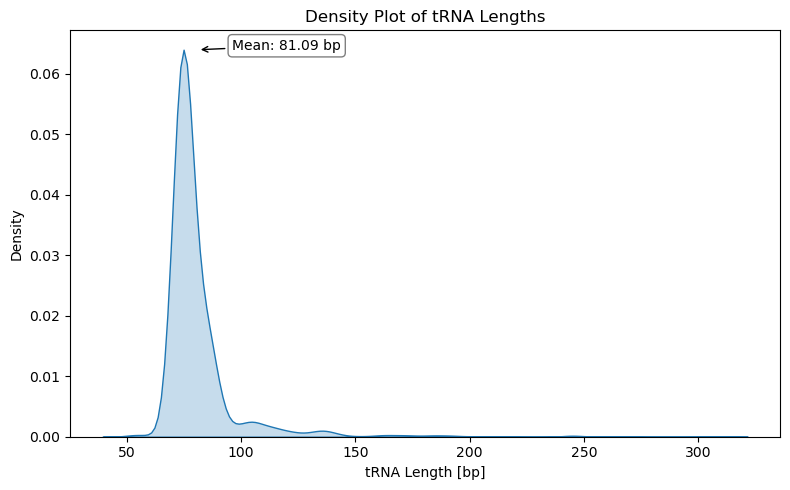

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
ax = sns.kdeplot(data=ss_df, x="length", fill=True)
plt.xlabel("tRNA Length [bp]")
plt.ylabel("Density")
plt.title("Density Plot of tRNA Lengths")

mean_length = ss_df["length"].values.mean()

# Annotate the peak
plt.annotate(f"Mean: {mean_length:.2f} bp",
             xy=(mean_length, 0.064),
             xytext=(mean_length + 15, 0.064),
             arrowprops=dict(arrowstyle="->", color="black"),
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1))

plt.tight_layout()
plt.show()

## Group tRNA sizes by superphyla, type, anticodon and aggregate

In [3]:
plot_data = (
    ss_df.groupby(['superphyla', 'type', 'anticodon'], as_index=False)
    .agg({'length': ['mean', 'std', 'max']})
)
plot_data

superphyla   type anticodon      length                
                                       mean        std  max
0       Asgard    Ala       CGC   75.000000   1.673320   77
1       Asgard    Ala       GGC   79.000000   8.602325  101
2       Asgard    Ala       TGC   75.333333   1.632993   78
3       Asgard    Arg       CCG   77.000000   1.414214   78
4       Asgard    Arg       CCT   79.181818   9.652131  108
..         ...    ...       ...         ...        ...  ...
190       TACK  Undet       NNN  101.555556  27.785388  169
191       TACK    Val       CAC   74.375000   1.187735   75
192       TACK    Val       GAC   74.727273   1.420627   78
193       TACK    Val       TAC   75.000000   1.414214   78
194       TACK   iMet       CAT   76.000000   1.802776   78

[195 rows x 6 columns]

## Visualize the data average tRNA size by superphyla

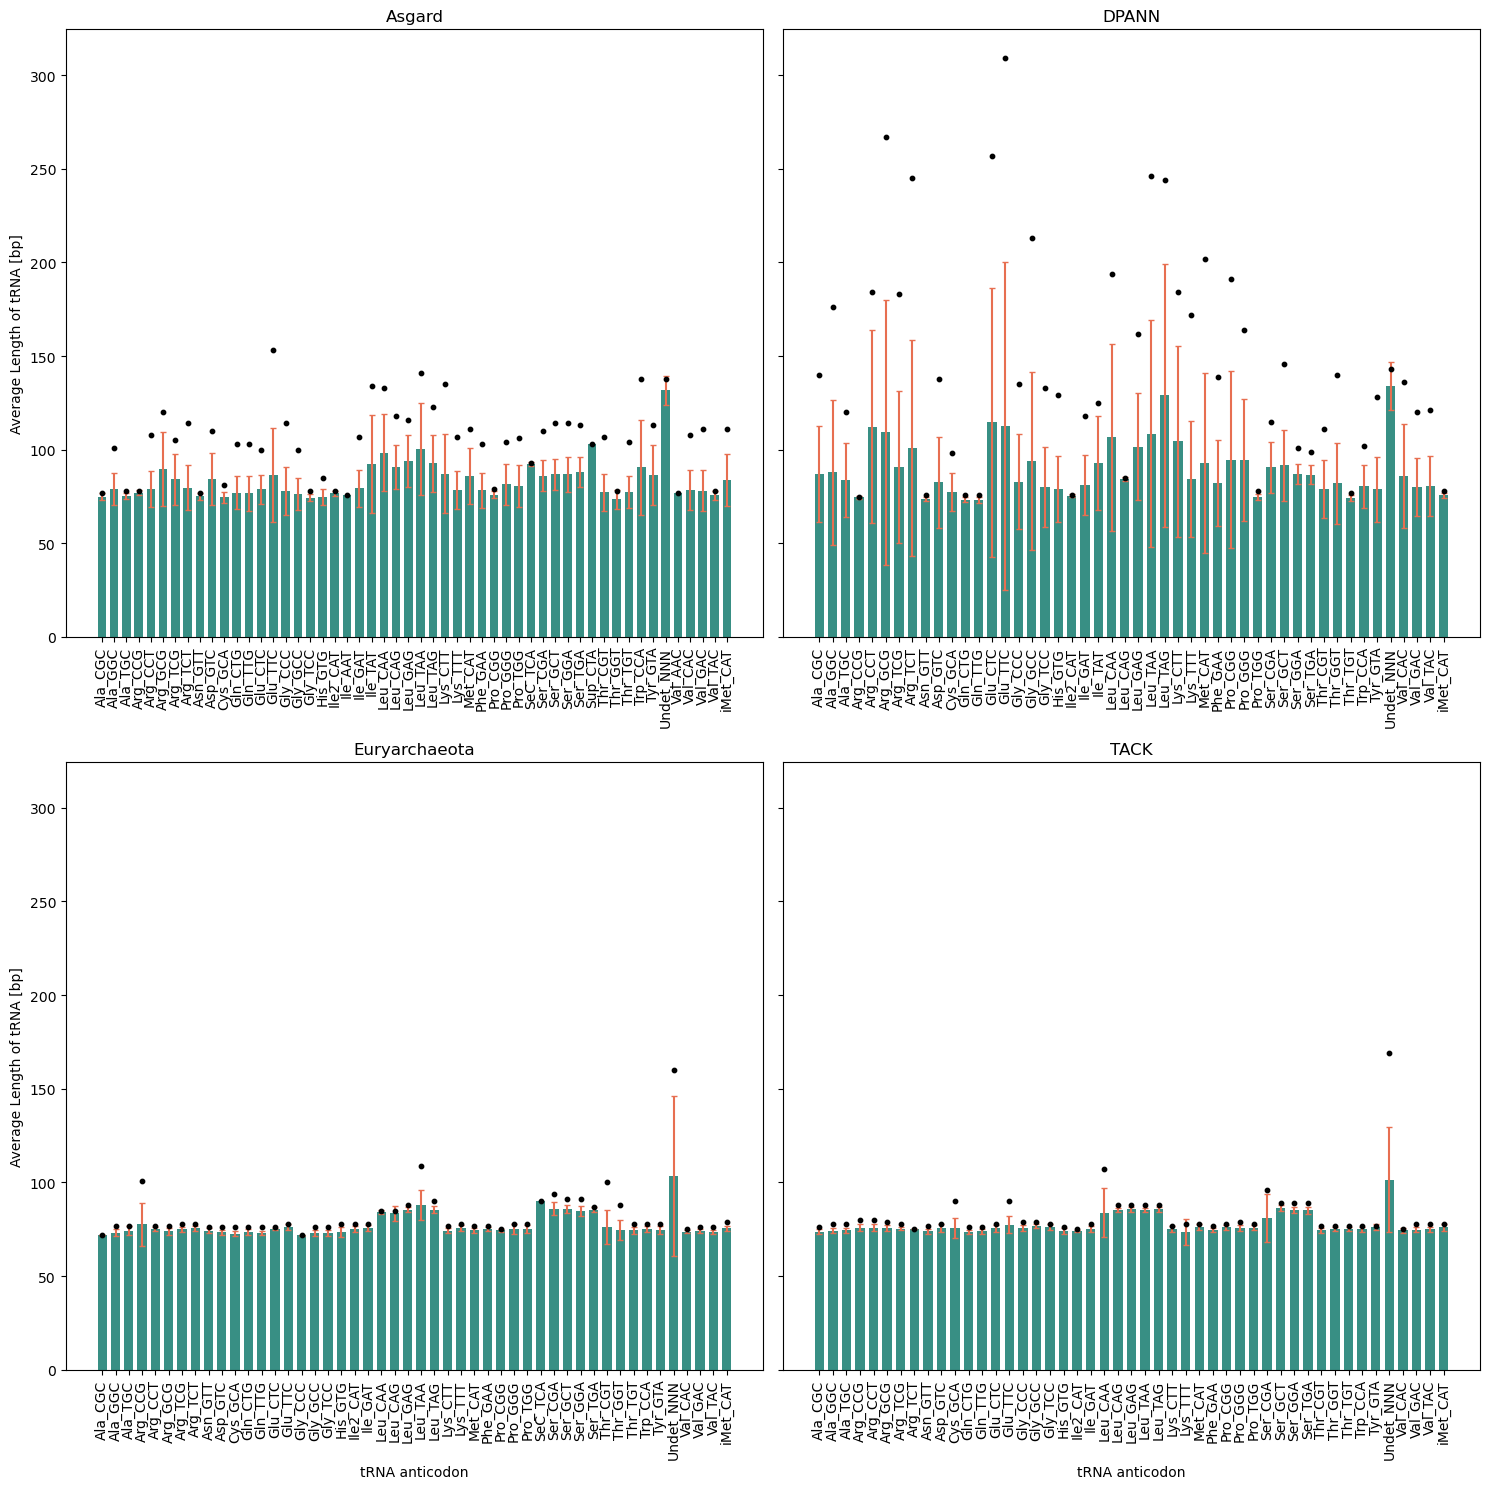

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data: group by superphyla, type, anticodon and calculate mean, std, and max length
plot_data = (
    ss_df.groupby(['superphyla', 'type', 'anticodon'], as_index=False)
    .agg({'length': ['mean', 'std', 'max']})
)
plot_data.columns = ['superphyla', 'type', 'anticodon', 'mean_length', 'std_length', 'max_length']
plot_data['type_anticodon'] = plot_data['type'] + '_' + plot_data['anticodon']

# Sort by superphyla and type_anticodon alphabetically
plot_data = plot_data.sort_values(['superphyla', 'type_anticodon'])

# Get unique superphyla (sorted)
superphyla_list = sorted(plot_data['superphyla'].unique())

bar_color = "#2a9d8f"  
error_color = "#e76f51" 

# Set up 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), sharey=True)
axes = axes.flatten()

for i, superphyla in enumerate(superphyla_list):
    data = plot_data[plot_data['superphyla'] == superphyla]
    
    bar = sns.barplot(
        data=data,
        x='type_anticodon',
        y='mean_length',
        color=bar_color,
        ax=axes[i],
        width=0.7,
        errorbar=None
    )
    # Add error bars manually
    axes[i].errorbar(
        x=range(len(data)),
        y=data['mean_length'],
        yerr=data['std_length'],
        fmt='none',
        ecolor=error_color,
        capsize=2,
        zorder=9
    )
    # Plot max length as dots
    axes[i].scatter(
        x=range(len(data)),
        y=data['max_length'],
        color='black',
        s=10,
        zorder=9,
        
    )
    axes[i].set_title(superphyla)    
    axes[i].set_ylabel('Average Length of tRNA [bp]')
    axes[i].tick_params(axis='x', rotation=90)

for idx, axis in enumerate(axes):
    if idx < 2:
        axis.set_xlabel("")
    else:    
        axis.set_xlabel('tRNA anticodon')

plt.tight_layout()
plt.show()

# Average isotype scores per tRNA-anticodon across superphyla

In [67]:
trnascan_df

,superphyla,id,name,trna_begin,trna_end,trna_type,anticodon,intron_begin,intron_end,inf_score,hmm_score,two_str_score,isotype_cm,isotype_score,note
0,Asgard,3045163_7,JASEJC010000001.trna1,55784,55692,Pro,CGG,55744,55730,73.4,49.60,23.8,Pro,108.7,CI
1,Asgard,3045163_7,JASEJC010000001.trna2,6278,6171,Leu,CAG,6256,6245,87.3,63.00,24.3,Leu,93.4,NCI:1
2,Asgard,3045163_7,JASEJC010000001.trna3,3123,3011,Thr,GGT,"3101,3064","3080,3050",69.2,43.60,25.6,Thr,92.1,"CI,NCI:1"
3,Asgard,3045163_7,JASEJC010000002.trna1,33406,33508,Leu,CAA,33439,33453,84.2,54.40,29.8,Leu,121.4,NCI:1
4,Asgard,3045163_7,JASEJC010000002.trna2,19905,19818,Ser,TGA,0,0,94.8,67.60,27.2,Ser,109.8,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,Asgard,2053491_86,JAGXKG010000007.trna5,47992,47887,Ala,GGC,47954,47926,69.6,51.80,17.8,Ala,84.5,CI
1673,Asgard,2053491_86,JAGXKG010000018.trna1,36790,36881,SeC,TCA,0,0,40.6,0.00,0.0,SeC,40.7,
1674,Asgard,2053491_86,JAGXKG010000028.trna1,15108,15252,Ser,GGA,15175,15205,51.0,18.10,32.9,Ser,83.2,CI
1675,Asgard,2053491_86,JAGXKG010000034.trna1,13530,13454,Cys,GCA,0,0,51.3,30.20,21.1,Cys,73.4,


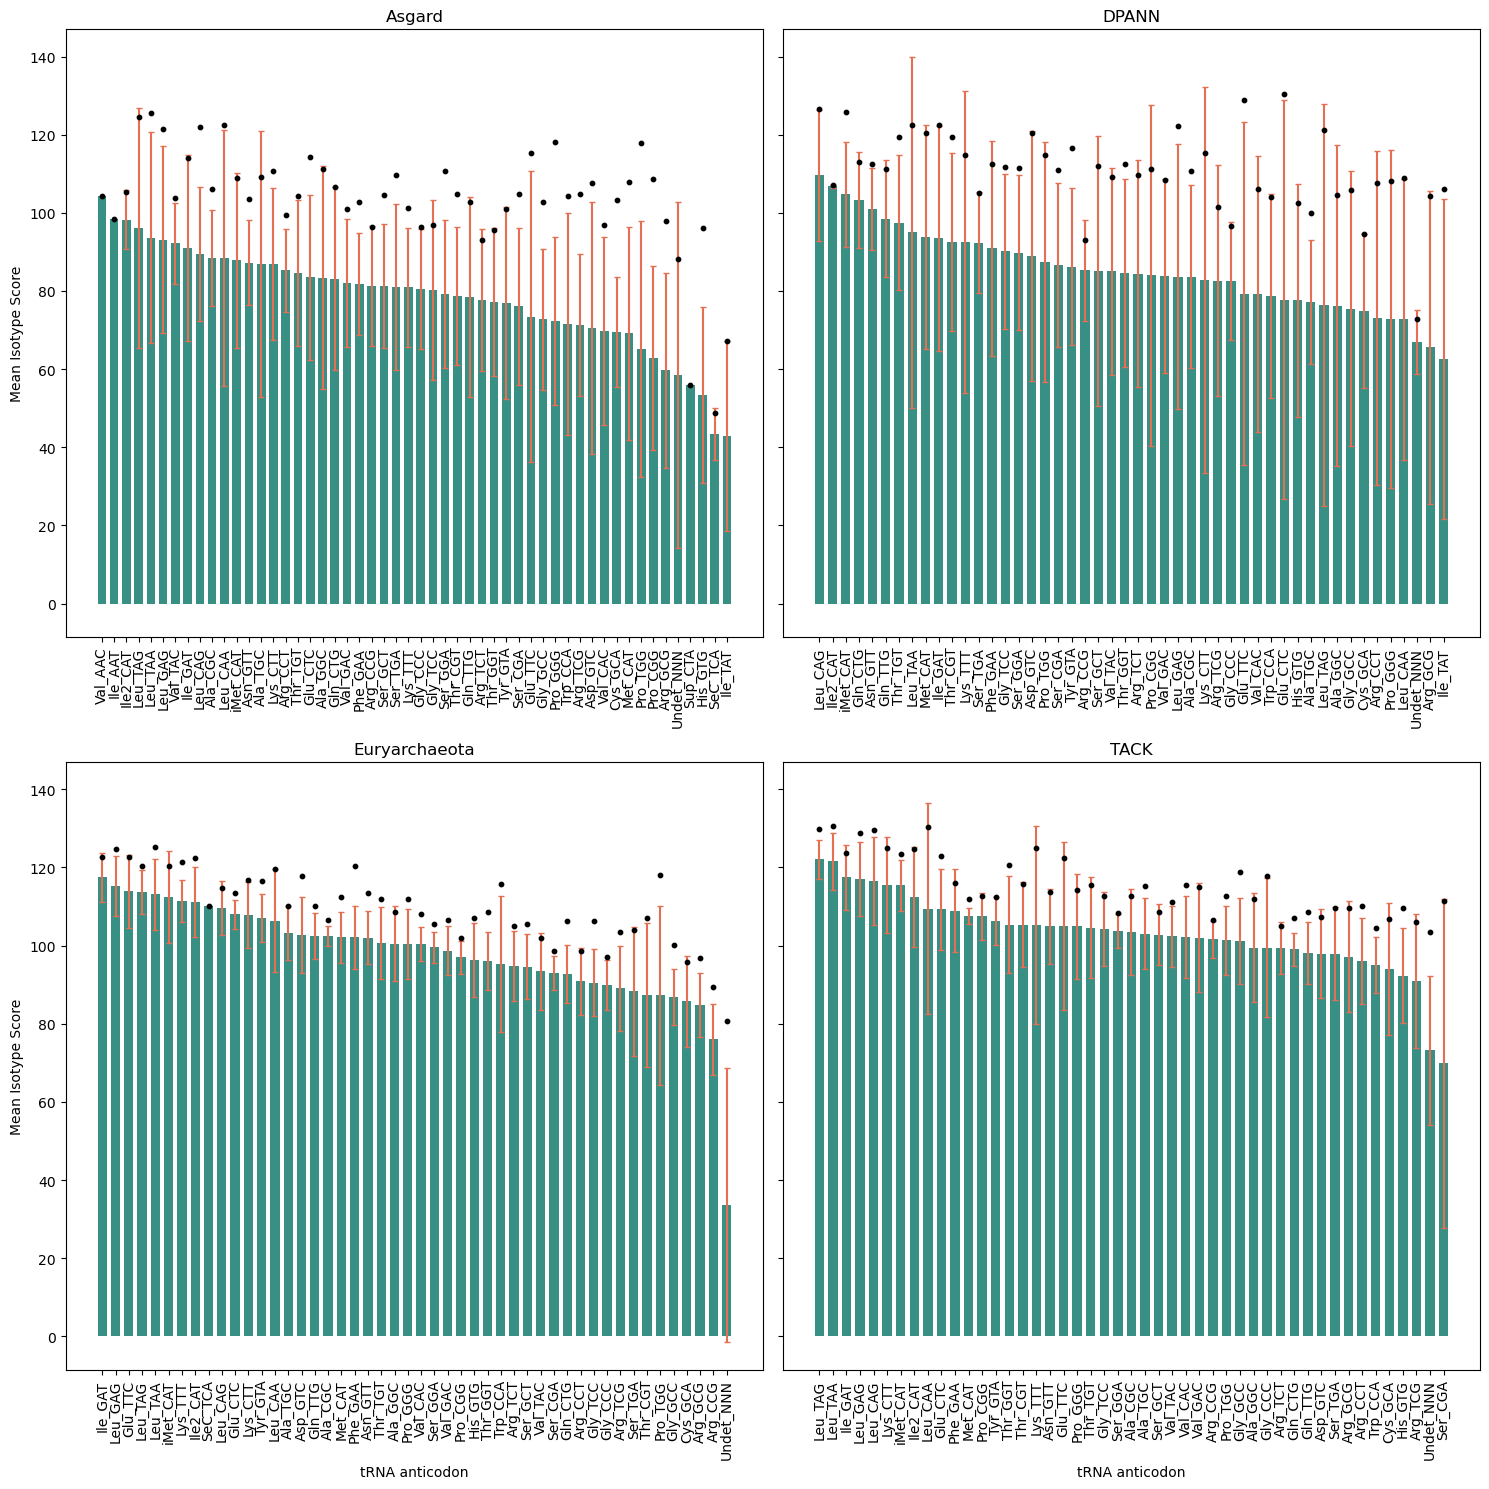

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data: group by superphyla, type, anticodon and calculate mean, std, and max length
plot_data = (
    trnascan_df.groupby(['superphyla', 'trna_type', 'anticodon'], as_index=False)
    .agg({'isotype_score': ['mean', 'std', 'max']})
)
plot_data.columns = ['superphyla', 'trna_type', 'anticodon', 'mean_isotype_score', 'std_isotype_score', 'max_isotype_score']
plot_data['type_anticodon'] = plot_data['trna_type'] + '_' + plot_data['anticodon']

# Sort by superphyla and type_anticodon alphabetically
plot_data = plot_data.sort_values(['superphyla', "mean_isotype_score"], ascending=False)

# Get unique superphyla (sorted)
superphyla_list = sorted(plot_data['superphyla'].unique())

bar_color = "#2a9d8f"  
error_color = "#e76f51" 

# Set up 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), sharey=True)
axes = axes.flatten()

for i, superphyla in enumerate(superphyla_list):
    data = plot_data[plot_data['superphyla'] == superphyla]
    
    bar = sns.barplot(
        data=data,
        x='type_anticodon',
        y='mean_isotype_score',
        color=bar_color,
        ax=axes[i],
        width=0.7,
        errorbar=None
    )
    # Add error bars manually
    axes[i].errorbar(
        x=range(len(data)),
        y=data['mean_isotype_score'],
        yerr=data['std_isotype_score'],
        fmt='none',
        ecolor=error_color,
        capsize=2,
        zorder=9
    )
    # Plot max length as dots
    axes[i].scatter(
        x=range(len(data)),
        y=data['max_isotype_score'],
        color='black',
        s=10,
        zorder=9,
        
    )
    axes[i].set_title(superphyla)    
    axes[i].set_ylabel('Mean Isotype Score')
    axes[i].tick_params(axis='x', rotation=90)

for idx, axis in enumerate(axes):
    if idx < 2:
        axis.set_xlabel("")
    else:    
        axis.set_xlabel('tRNA anticodon')

plt.tight_layout()
plt.show()

## Isotype scores by anticodon and tRNA type across superphyla

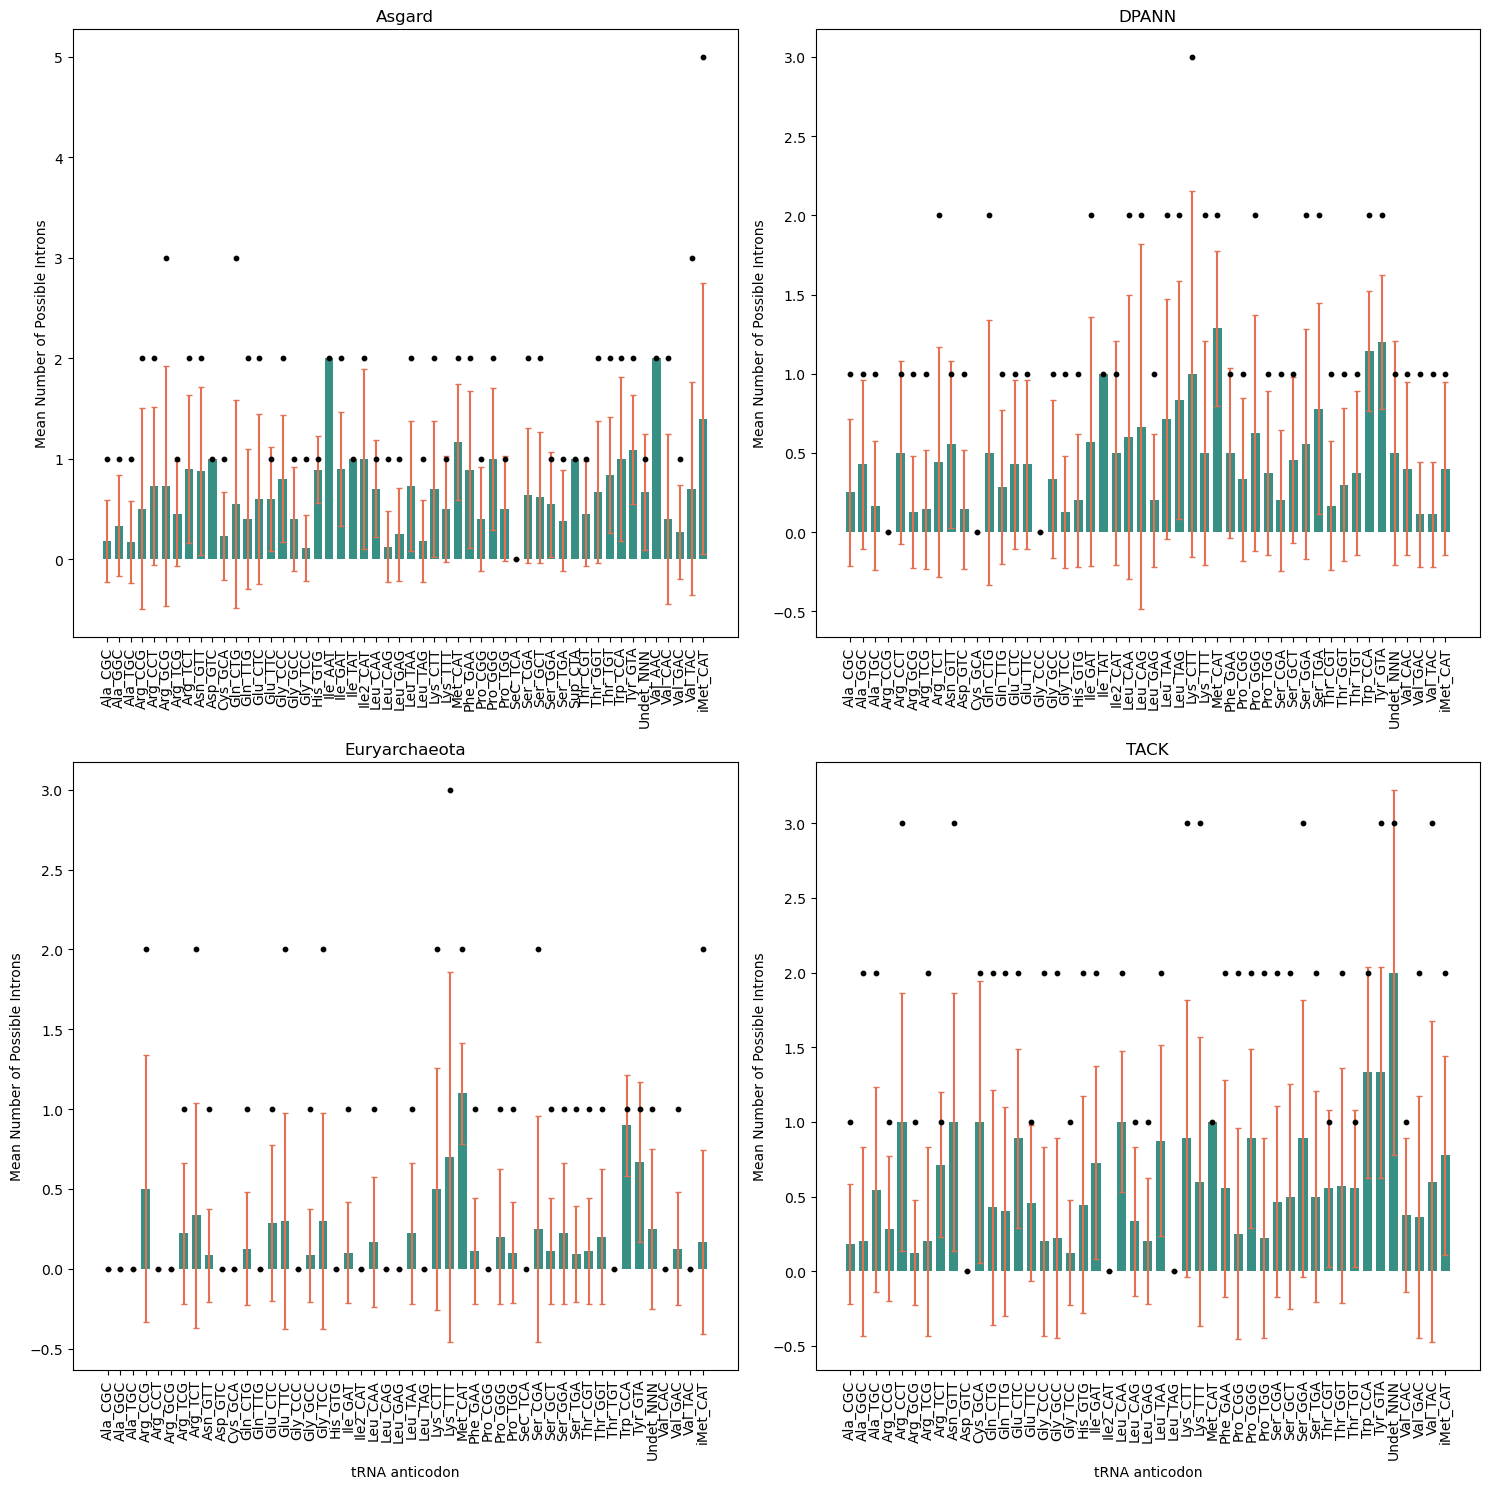

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data: group by superphyla, type, anticodon and calculate mean, std, and max length
plot_data = (
    ss_df.groupby(['superphyla', 'type', 'anticodon'], as_index=False)
    .agg({'possible_intron_n': ['mean', 'std', 'max']})
)
plot_data.columns = ['superphyla', 'type', 'anticodon', 'mean_possible_intron_n', 'std_possible_intron_n', 'max_possible_intron_n']
plot_data['type_anticodon'] = plot_data['type'] + '_' + plot_data['anticodon']

# Sort by superphyla and type_anticodon alphabetically
plot_data = plot_data.sort_values(['superphyla', "type"])

# Get unique superphyla (sorted)
superphyla_list = sorted(plot_data['superphyla'].unique())

bar_color = "#2a9d8f"  
error_color = "#e76f51" 

# Set up 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), sharey=False)
axes = axes.flatten()

for i, superphyla in enumerate(superphyla_list):
    data = plot_data[plot_data['superphyla'] == superphyla]
    
    bar = sns.barplot(
        data=data,
        x='type_anticodon',
        y='mean_possible_intron_n',
        color=bar_color,
        ax=axes[i],
        width=0.7,
        errorbar=None
    )
    # Add error bars manually
    axes[i].errorbar(
        x=range(len(data)),
        y=data['mean_possible_intron_n'],
        yerr=data['std_possible_intron_n'],
        fmt='none',
        ecolor=error_color,
        capsize=2,
        zorder=9
    )
    # Plot max length as dots
    axes[i].scatter(
        x=range(len(data)),
        y=data['max_possible_intron_n'],
        color='black',
        s=10,
        zorder=9,
        
    )
    axes[i].set_title(superphyla)    
    axes[i].set_ylabel('Mean Number of Possible Introns')
    axes[i].tick_params(axis='x', rotation=90)

for idx, axis in enumerate(axes):
    if idx < 2:
        axis.set_xlabel("")
    else:    
        axis.set_xlabel('tRNA anticodon')

plt.tight_layout()
plt.show()

## Heatmap of Intron Positions by Superphyla

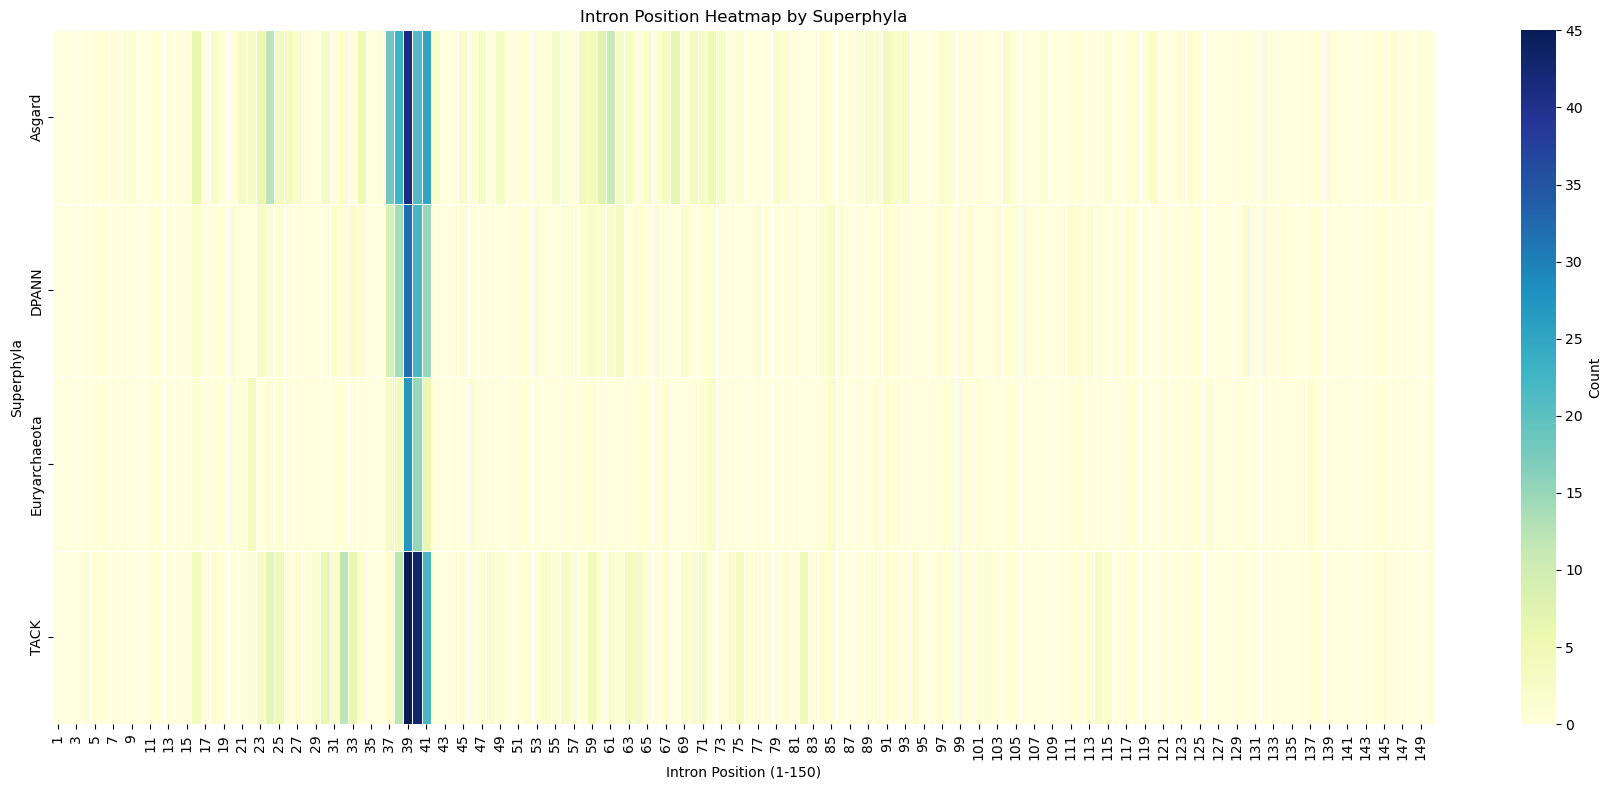

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set index to superphyla for heatmap
heatmap_data = pos_df.groupby('superphyla')[position_cols].sum()

plt.figure(figsize=(18, 8))  
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    cbar_kws={'label': 'Count'},
    linewidths=0.5
)
plt.xlabel("Intron Position (1-150)")
plt.ylabel("Superphyla")
plt.title("Intron Position Heatmap by Superphyla")
plt.tight_layout()
plt.show()
